In [17]:
from dataman.audio_processing import *

import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

## Renewing the data within the database

The first batch of data collected for the database (in "datasets/keystrokes_00") contained too few, too diversified sound data for each key type that no meaningful progress could be made for the supervised proof-of-concept model. To fix this, the data within the database will be overhauled from scratch by recollecting data for each key type once again, with a particular focus on consistency of keystroke sound. By artifically constraining the variance of sound data for each key type, I hope to have an easier time generating meaningful output for the proof of concept.

In [4]:
keystroke_data = collect_keystroke_data('/env/datasets/keystrokes/', output=True)

> Reading files from /env/datasets/keystrokes/a/ for key "a"
  > Extracting keystrokes from "a-x.wav" => Collected 123 keystrokes
> Reading files from /env/datasets/keystrokes/b/ for key "b"
  > Extracting keystrokes from "b-x.wav" => Collected 108 keystrokes
> Reading files from /env/datasets/keystrokes/c/ for key "c"
  > Extracting keystrokes from "c-x.wav" => Collected 156 keystrokes
> Reading files from /env/datasets/keystrokes/d/ for key "d"
  > Extracting keystrokes from "d-x.wav" => Collected 150 keystrokes
> Reading files from /env/datasets/keystrokes/e/ for key "e"
  > Extracting keystrokes from "e-x.wav" => Collected 159 keystrokes
> Reading files from /env/datasets/keystrokes/f/ for key "f"
  > Extracting keystrokes from "f-x.wav" => Collected 195 keystrokes
> Reading files from /env/datasets/keystrokes/g/ for key "g"
  > Extracting keystrokes from "g-x.wav" => Collected 153 keystrokes
> Reading files from /env/datasets/keystrokes/h/ for key "h"
  > Extracting keystrokes fro

In [15]:
create_keystroke_table()

store_keystroke_data(keystroke_data, os.environ['TEST_DATABASE_URL'])

In [2]:
data, labels = load_keystroke_data(os.environ['TEST_DATABASE_URL'])

## Supervised Training (Initial Attempt)

In [3]:
scaled_data = scale_keystroke_data(data)

In [21]:
# 90% training, 10% testing
training_count = int(len(scaled_data) * 0.9)
x_train, x_test = scaled_data[:training_count], scaled_data[training_count:]
y_train, y_test = labels[:training_count], labels[training_count:]

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(29, activation='softmax'),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
3987/3987 [==============================] - 2s 600us/sample - loss: 3.7046 - accuracy: 0.0296
Epoch 2/5
3987/3987 [==============================] - 1s 298us/sample - loss: 3.3659 - accuracy: 0.0416
Epoch 3/5
3987/3987 [==============================] - 1s 306us/sample - loss: 3.3647 - accuracy: 0.0426
Epoch 4/5
3987/3987 [==============================] - 1s 299us/sample - loss: 3.3637 - accuracy: 0.0426
Epoch 5/5
444/444 [==============================] - 0s 402us/sample - loss: 3.3636 - accuracy: 0.0563


[3.3636162946890065, 0.056306306]

The classifying accuracy is ~5.6%, which is pretty low. But I guess this is to be expected due to how similar certain groups of key types sound relative to each other. A logical next step seems to be clustering and visualizing each keystroke to observe whether the the low classifying accuracy is due to keystrokes being extremely indistinguishable or clusters being distinguishable, but lack enough variance between similar clusters.

## Clustering the data

Clustering the data naively into 29 clusters within a 13,230 dimension space (like below) would likely take a absurdly long time. Instead, I should preprocess the data beforehand to reduce the number of dimensions. The important aspects of each keystroke data are the points and widths of the peaks. Values below the silence threshold don't matter at all, so those portions can just be regarded as "0". So maybe sample each data in with lower frequency, with higher frequency around the first 0.2 seconds or so to capture the peak details.

In [ ]:
kmeans = KMeans(n_clusters=29, random_state=0).fit(data)

After some research, I've determined that t-SNE (t-Distributed Stochastic Neighbor Embedding) is a good candidate for visualizing the keystroke data within a 2 or 3 dimensional space. sklearn already has it implemented, so I will attempt to use that in order to proceed with my project.

In [4]:
data_embedded = TSNE().fit_transform(data)

In [5]:
data_embedded

array([[ -2.8367538,   6.9395885],
       [ 11.57649  ,   8.389993 ],
       [ 19.378286 , -27.454933 ],
       ...,
       [-12.905319 ,  -3.1751451],
       [-35.89974  ,  -9.08714  ],
       [ 16.657808 ,  18.337128 ]], dtype=float32)

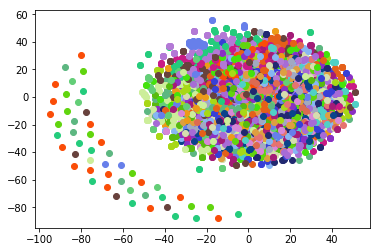

In [33]:
keytype_id = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l',
             12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 
             23: 'x', 24: 'y', 25: 'z', 26: 'space', 27: 'period', 28: 'enter'}
color_map = {}
for i in range(29):
    color_map[i] = np.random.rand(3,)
    
x = [v[0] for v in data_embedded]
y = [v[1] for v in data_embedded]

for i in range(len(data_embedded)):
    plt.plot(x[i], y[i], color=color_map[labels[i]], marker='o')
plt.show()